In [3]:
!pip install pandas matplotlib

     |████████████████████████████████| 12.4 MB 8.0 MB/s eta 0:00:01
     |████████████████████████████████| 9.2 MB 51.2 MB/s eta 0:00:01     |███████████████████████         | 6.6 MB 51.2 MB/s eta 0:00:01
     |████████████████████████████████| 505 kB 145.7 MB/s eta 0:00:01
     |████████████████████████████████| 17.3 MB 48.7 MB/s eta 0:00:01
     |████████████████████████████████| 345 kB 134.1 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 138.8 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 50.6 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 49.9 MB/s eta 0:00:01
     |████████████████████████████████| 103 kB 76.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 51.7 MB/s eta 0:00:01


In [86]:
from typing import List, Dict, Tuple

import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

__WORKING_BRANCH_PATH = (
    "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch"
)

hatch = {
    'Vector': '',
    'Vectorpreallocated': '||||',
    'Skiplist': '\\\\\\\\\\\\',
    'Hashskiplist': '//',
    'Hashlinklist': '----',
    'Mean': '',
    'Median': '||||||',
    'Max': '\\\\\\\\\\\\',
    '95th': '//',
    '98th': '----',
    '99th': '\\\\'
}

linestyle = {
    'vector': '-',
    'vectorpreallocated': '--',
    'skiplist': '--',
    'hashskiplist': '-.',
    'hashlinklist': ':'
}

alpha = {
    'Vector': 1,
    'Vectorpreallocated': 1,
    'Skiplist': 0.8,
    'Hashskiplist': 1,
    'Hashlinklist': 1,
}

color = {
    # 'Vector': 'darkslateblue',
    # 'Skiplist': 'slategray',
    # 'Hashskiplist': 'darkkhaki',
    # 'Hashlinklist': 'chocolate'
    'Vector': 'black',
    'Vectorpreallocated': 'black',
    'Skiplist': 'black',
    'Hashskiplist': 'black',
    'Hashlinklist': 'black'
}

linewidth = {
    'Vector': 1,
    'Vectorpreallocated': 1,
    'Skiplist': 1,
    'Hashskiplist': 1,
    'Hashlinklist': 1,
}

edgecolor = {
    'Vector': 'black',
    'Vectorpreallocated': 'black',
    'Skiplist': 'black',
    'Hashskiplist': 'black',
    'Hashlinklist': 'black',
    'Mean': 'black',
    'Median': 'black',
    'Max': 'black',
    '95th': 'black',
    '98th': 'black',
    '99th': 'black'
}

label = {
    'vector': 'vector',
    'vectorpreallocated': 'vector preallocated',
    'skiplist': 'skiplist',
    'hashskiplist': 'hash skiplist',
    'hashlinklist': 'hash linklist',
    'Mean': 'mean',
    'Median': 'median',
    'Max': 'max',
    '95th': '95th',
    '98th': '98th',
    '99th': '99th'
}

plt.rcParams["font.family"] = "serif"

alphabets = "abcdefghijklmnopqrstuvwxyz"

In [83]:
def get_properties(key: str) -> Dict[str, str]:
    if key.lower() in label:
        return {
            # "label": label.get(key.capitalize()),
            "color": "black",
            # "edgecolor": edgecolor.get(key.capitalize()) or "None",
            "linestyle": linestyle.get(key.lower()),
            # "hatch": hatch.get(key.capitalize()),
            # "linewidth": linewidth.get(key.capitalize()),
            # "alpha": alpha.get(key.capitalize()),
        }
    else:
        raise ValueError(f"Unknown key: {key}")

In [11]:
def get_exp_dirname(query_type: str, selectivity: float, entry_size: int, pqs: int, epp: int) -> str:
    return (
        f"{__WORKING_BRANCH_PATH}/experiments-{query_type}-{selectivity}-{entry_size}-{epp}-PQS-{pqs}"
    )


def get_log_file_path(
    query_type: str,
    inserts: int,
    point_queries: int,
    range_queries: int,
    selectivity: float,
    memtable: str,
    entry_size: int,
    number_of_entries_per_page: int,
    number_of_pages: int,
    prefixlen: int = 0,
    bucket_count: int = 0,
    size_ratio: int = 4,
    updates: int = 0,
):
    if memtable.lower() in ("hashskiplist", "hashlinklist"):
        return f"{get_exp_dirname(query_type, selectivity, entry_size, point_queries, number_of_entries_per_page)}/I {inserts} U {updates} S {range_queries} Y {selectivity} Q {point_queries} m {memtable.lower()} E {entry_size} B {number_of_entries_per_page} P {number_of_pages} T {size_ratio} l {prefixlen} bucket_count {bucket_count}/workload.log"
    return f"{get_exp_dirname(query_type, selectivity, entry_size, point_queries, number_of_entries_per_page)}/I {inserts} U {updates} S {range_queries} Y {selectivity} Q {point_queries} m {memtable.lower()} E {entry_size} B {number_of_entries_per_page} P {number_of_pages} T {size_ratio}/workload.log"

In [12]:
def prepare_dataframe(log_file_path: str, key: str="RangeQueryTime: ") -> pd.DataFrame:
    ff = open(log_file_path, "r")
    range_quereis = []

    for line in ff.readlines():
        if key in line:
            range_quereis.append(float(line.split(" ")[1]))
    
    return pd.DataFrame(range_quereis, columns=["TimeTaken"])


In [121]:
point_queries = [12, 240, 960, 1200] #, 120, 2400, 7200, 12000]
memtables = ["Vector", "SkipList", "Hashskiplist", "Hashlinklist"]
prefixlen = 4
bucket_count = 100000
entry_size = 64
inserts = 120000
range_queries = 0
number_of_entries_per_page = 64
number_of_pages = 4096
updates = 0
selectivity = 0


data = {
    "vector": [],
    "skiplist": [], 
    "hashskiplist": [], 
    "hashlinklist": [],
}

for pqs in point_queries:

    for memtable in memtables:
        query_type = "Interleaved-PQ-"
        query_type += memtable.lower()

        path = get_log_file_path(
            query_type,
            inserts,
            pqs,
            range_queries,
            selectivity,
            memtable,
            entry_size,
            number_of_entries_per_page,
            number_of_pages,
            prefixlen,
            bucket_count,
        )

        df = prepare_dataframe(path, "PointQueryTime:")

        print
        data[memtable.lower()].append({
            "pointQueries": pqs,
            "AvgPointQueryLatency": df["TimeTaken"].mean()
        })




In [122]:
data

{'vector': [{'pointQueries': 12, 'AvgPointQueryLatency': 31868993.0},
  {'pointQueries': 240, 'AvgPointQueryLatency': 23391762.520833332},
  {'pointQueries': 960, 'AvgPointQueryLatency': 19285118.605208334},
  {'pointQueries': 1200, 'AvgPointQueryLatency': 19312605.85}],
 'skiplist': [{'pointQueries': 12, 'AvgPointQueryLatency': 3424.8333333333335},
  {'pointQueries': 240, 'AvgPointQueryLatency': 2665.320833333333},
  {'pointQueries': 960, 'AvgPointQueryLatency': 2459.235416666667},
  {'pointQueries': 1200, 'AvgPointQueryLatency': 2122.32}],
 'hashskiplist': [{'pointQueries': 12,
   'AvgPointQueryLatency': 2283.0833333333335},
  {'pointQueries': 240, 'AvgPointQueryLatency': 1868.9375},
  {'pointQueries': 960, 'AvgPointQueryLatency': 1482.1552083333333},
  {'pointQueries': 1200, 'AvgPointQueryLatency': 1212.2191666666668}],
 'hashlinklist': [{'pointQueries': 12,
   'AvgPointQueryLatency': 3933.3333333333335},
  {'pointQueries': 240, 'AvgPointQueryLatency': 1673.5625},
  {'pointQueries':

In [123]:
data['vector']

[{'pointQueries': 12, 'AvgPointQueryLatency': 31868993.0},
 {'pointQueries': 240, 'AvgPointQueryLatency': 23391762.520833332},
 {'pointQueries': 960, 'AvgPointQueryLatency': 19285118.605208334},
 {'pointQueries': 1200, 'AvgPointQueryLatency': 19312605.85}]

In [124]:
point_queries
[d['AvgPointQueryLatency'] for d in sorted(data['vector'], key=lambda x: x['pointQueries'])]

[31868993.0, 23391762.520833332, 19285118.605208334, 19312605.85]

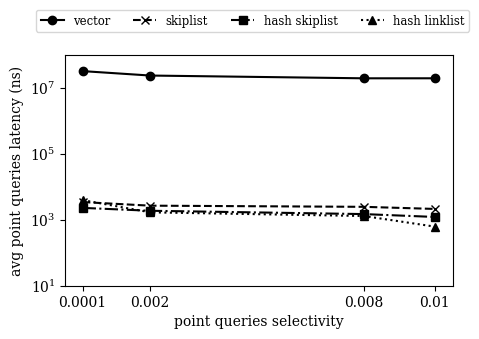

In [125]:
fig, ax = plt.subplots(figsize=(5,3))

xpoints = [p/inserts for p in point_queries]

ax.plot(
    xpoints,
    [d['AvgPointQueryLatency'] for d in sorted(data['vector'], key=lambda x: x['pointQueries'])],
    label='vector',
    **get_properties('vector'),
    marker='o'
)

ax.plot(
    xpoints,
    [d['AvgPointQueryLatency'] for d in sorted(data['skiplist'], key=lambda x: x['pointQueries'])],
    label='skiplist',
    **get_properties('skiplist'),
    marker='x'
)

ax.plot(
    xpoints,
    [d['AvgPointQueryLatency'] for d in sorted(data['hashskiplist'], key=lambda x: x['pointQueries'])],
    label='hash skiplist',
    **get_properties('hashskiplist'),
    marker='s'
)

ax.plot(
    xpoints,
    [d['AvgPointQueryLatency'] for d in sorted(data['hashlinklist'], key=lambda x: x['pointQueries'])],
    label='hash linklist',
    **get_properties('hashlinklist'),
    marker='^'
)

ax.set_xticks(xpoints)
ax.set_xticklabels([f"{p/inserts}" for p in point_queries])

ax.set_ylabel('avg point queries latency (ns)')
ax.set_xlabel('point queries selectivity')
ax.set_ylim(bottom=10**1, top=10**8)

# ax.legend()
ax.set_yscale('log')

fig.legend(loc='upper center', ncol=4, fontsize='small', bbox_to_anchor=(0.5, 1.05))
plt.show()

In [61]:
point_queries[0]/inserts

0.0001

In [62]:
xpoints

[0.0001, 0.001, 0.002, 0.008, 0.01, 0.1]